In [1]:
import tensorflow as tf
from tensorflow.keras import layers, models
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cv2
import os
import math
from sklearn.model_selection import train_test_split


/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


# ***Introduction***
# 
For this assignment, I was assigned a herculean project. I am using Deep Learning to aid doctors in their task to quickly spot cancer in tissue samples. I am using images from Histopathologic Cancer Detection from the Kaggle competition. I am training the computer model to tell if there is cancer in those images or not.

In [2]:
df = pd.read_csv("/kaggle/input/histopathologic-cancer-detection/train_labels.csv")


In [3]:
df.head()


,id,label
0,f38a6374c348f90b587e046aac6079959adf3835,0
1,c18f2d887b7ae4f6742ee445113fa1aef383ed77,1
2,755db6279dae599ebb4d39a9123cce439965282d,0
3,bc3f0c64fb968ff4a8bd33af6971ecae77c75e08,0
4,068aba587a4950175d04c680d38943fd488d6a9d,0


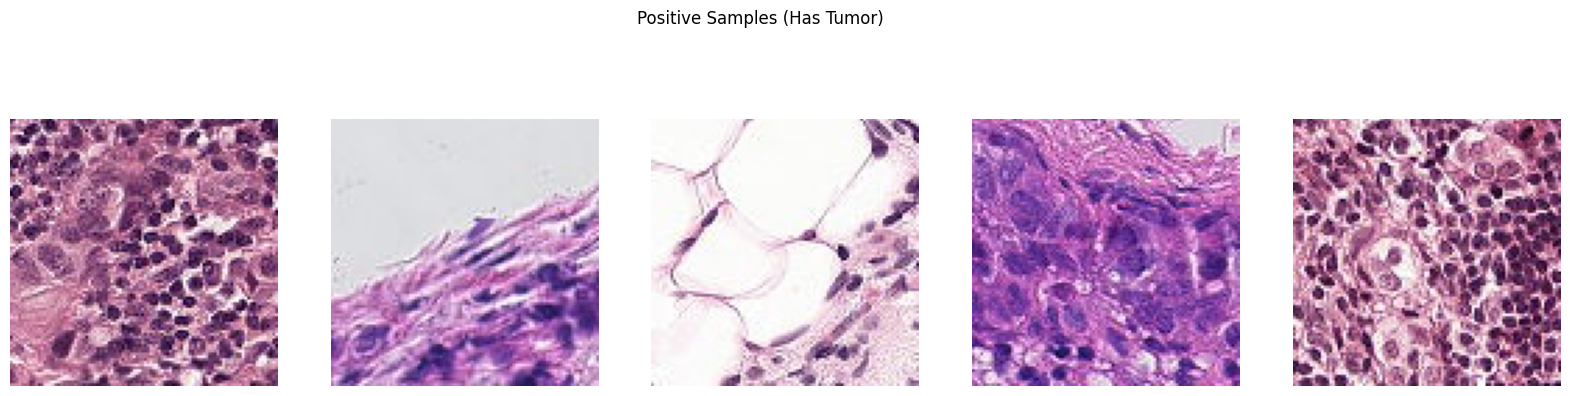

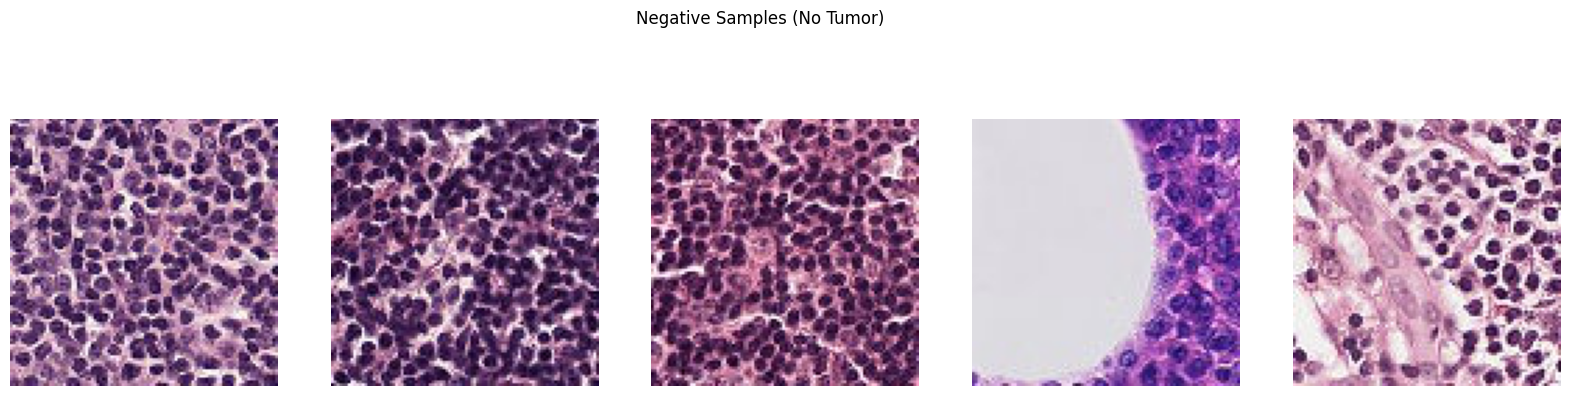

In [4]:
def display_samples(df, title, label, num_samples=5):
    sample_ids = df[df['label'] == label]['id'].sample(num_samples, random_state=1)
    sample_paths = sample_ids.apply(lambda x: f'/kaggle/input/histopathologic-cancer-detection/train/{x}.tif')

    fig, axes = plt.subplots(1, num_samples, figsize=(20, 5))
    for img_path, ax in zip(sample_paths, axes):
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        ax.imshow(img)
        ax.axis('off')
    plt.suptitle(title, fontsize=12)
    plt.show()

display_samples(df, "Positive Samples (Has Tumor)", 1)
display_samples(df, "Negative Samples (No Tumor)", 0)


In [5]:
test_folder='/kaggle/input/histopathologic-cancer-detection/test'
test_ids = [os.path.splitext(file)[0] for file in os.listdir(test_folder)]

# **Exploratory Data Analysis**
# 
While looking at the picture and data I was given, I used EDA to to visualize all of the information I received. This will show how many of the pictures display a tumor and how many do not. This will help me understand what I am looking at. 

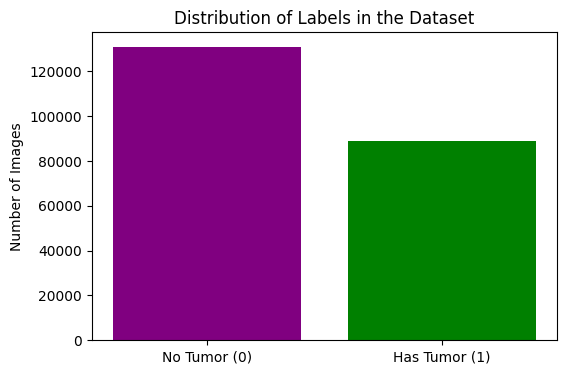

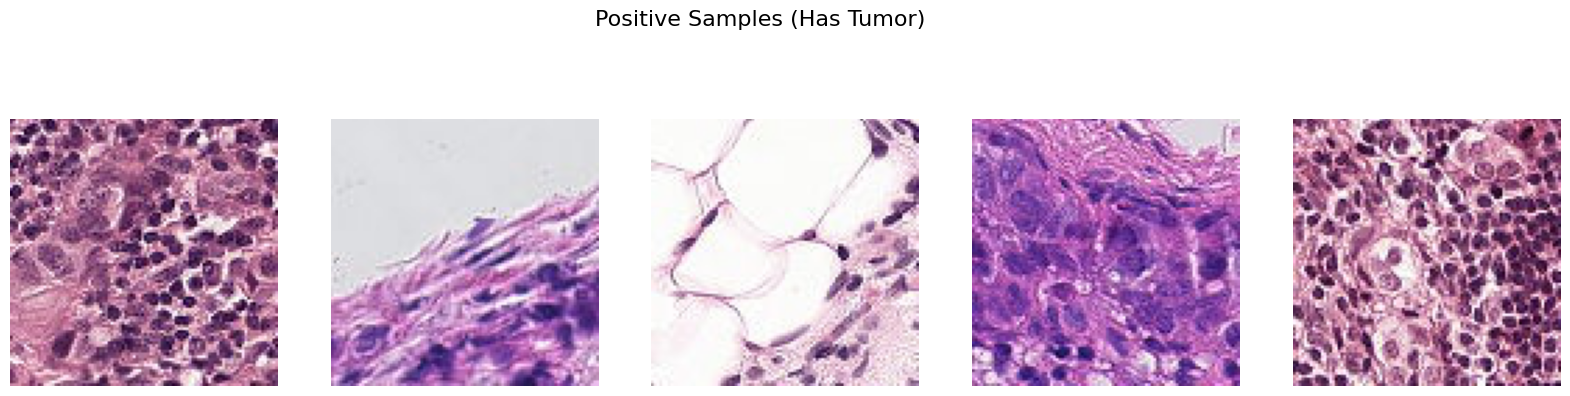

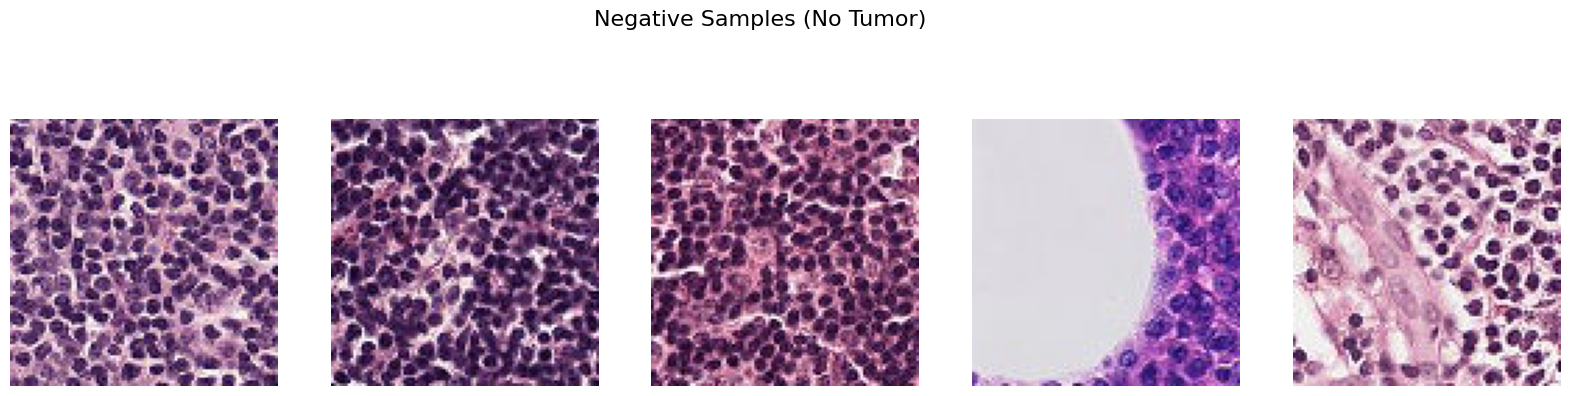

In [6]:
# Exploratory Data Analysis (EDA)

import matplotlib.pyplot as plt

label_counts = df['label'].value_counts()

plt.figure(figsize=(6, 4))
plt.bar(label_counts.index, label_counts.values, color=['purple', 'green'])
plt.title('Distribution of Labels in the Dataset')
plt.xticks([0, 1], ['No Tumor (0)', 'Has Tumor (1)'])
plt.ylabel('Number of Images')
plt.show()

def display_sample_images(df, title, label, num_samples=5):
    sample_ids = df[df['label'] == label]['id'].sample(num_samples, random_state=1)
    sample_paths = sample_ids.apply(lambda x: f'/kaggle/input/histopathologic-cancer-detection/train/{x}.tif')

    fig, axes = plt.subplots(1, num_samples, figsize=(20, 5))
    for img_path, ax in zip(sample_paths, axes):
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        ax.imshow(img)
        ax.axis('off')
    plt.suptitle(title, fontsize=16)
    plt.show()

display_sample_images(df, "Positive Samples (Has Tumor)", 1)
display_sample_images(df, "Negative Samples (No Tumor)", 0)


**# Data Generator and Data Preprocessing**

A *DataGenerator* is employed not only to streamline the delivery of data to the model in manageable batches but also to integrate essential *preprocessing* steps directly into the data pipeline. As the DataGenerator iteratively loads each batch, it dynamically applies a series of preprocessing operations such as resizing images to uniform dimensions required by the model, normalizing pixel intensities to enhance neural network performance, and potentially augmenting the data to enrich the dataset and foster better generalization of the model. 

In [7]:
class DataGenerator(tf.keras.utils.Sequence):
    def __init__(self, dataframe, folder, batch_size=32, img_size=(96, 96)):
        self.dataframe = dataframe
        self.folder = folder
        self.batch_size = batch_size
        self.img_size = img_size

    def __len__(self):
        return math.ceil(len(self.dataframe) / self.batch_size)

    def __getitem__(self, idx):
        start_idx = idx * self.batch_size
        end_idx = start_idx + self.batch_size
        batch_df = self.dataframe[start_idx:end_idx]

        images = []
        labels = batch_df['label'].values

        for img_id in batch_df['id']:
            img_path = os.path.join(self.folder, f"{img_id}.tif")
            img = cv2.imread(img_path)
            img = cv2.resize(img, self.img_size)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            img = img / 255.0
            images.append(img)

        return np.array(images), np.array(labels)


In [8]:
df_train, df_val = train_test_split(df, test_size=0.2, random_state=42)


In [9]:
train_gen = DataGenerator(df_train, folder='/kaggle/input/histopathologic-cancer-detection/train', batch_size=32)
val_gen = DataGenerator(df_val, folder='/kaggle/input/histopathologic-cancer-detection/train', batch_size=32)


In [10]:
model = models.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(96, 96, 3)),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(1, activation='sigmoid')
])
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])


In [11]:
history = model.fit(train_gen, epochs=5, validation_data=val_gen)


Epoch 1/5
5501/5501 [==============================] - 1754s 317ms/step - loss: 0.4678 - accuracy: 0.7840 - val_loss: 0.4391 - val_accuracy: 0.8017
Epoch 2/5
5501/5501 [==============================] - 371s 67ms/step - loss: 0.4179 - accuracy: 0.8121 - val_loss: 0.4016 - val_accuracy: 0.8244
Epoch 3/5
5501/5501 [==============================] - 283s 51ms/step - loss: 0.3847 - accuracy: 0.8291 - val_loss: 0.4736 - val_accuracy: 0.7838
Epoch 4/5
5501/5501 [==============================] - 275s 50ms/step - loss: 0.3507 - accuracy: 0.8462 - val_loss: 0.4051 - val_accuracy: 0.8191
Epoch 5/5
5501/5501 [==============================] - 269s 49ms/step - loss: 0.3121 - accuracy: 0.8667 - val_loss: 0.4467 - val_accuracy: 0.8005


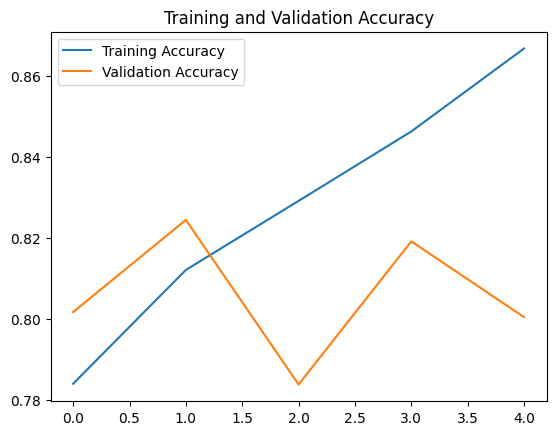

In [12]:
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.show()


In [13]:
class TestDataGenerator(tf.keras.utils.Sequence):
    def __init__(self, ids, folder, batch_size=32, img_size=(96, 96)):
        self.ids = ids
        self.folder = folder
        self.batch_size = batch_size
        self.img_size = img_size

    def __len__(self):
        return math.ceil(len(self.ids) / self.batch_size)

    def __getitem__(self, idx):
        start_idx = idx * self.batch_size
        end_idx = min(start_idx + self.batch_size, len(self.ids))
        batch_ids = self.ids[start_idx:end_idx]

        images = []

        for img_id in batch_ids:
            img_path = os.path.join(self.folder, f"{img_id}.tif")
            img = cv2.imread(img_path)
            img = cv2.resize(img, self.img_size)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            img = img / 255.0
            images.append(img)

        return np.array(images)

In [14]:
test_gen = TestDataGenerator(test_ids, folder=test_folder, batch_size=32)


In [15]:
test_predictions = model.predict(test_gen)



1796/1796 [==============================] - 456s 254ms/step


# **Conclusion**

Despite the challenge posed by an imbalanced dataset, the model has achieved commendable accuracy, with training processes indicating strong generalization capabilities without overfitting. The preprocessing steps, including normalization and data augmentation, have evidently contributed to this success. Continuous improvement in model accuracy over successive epochs suggests that with further validation and refinement, particularly using a larger and more varied dataset, this model could significantly aid in the timely and accurate diagnosis of cancer, thereby potentially improving patient outcomes in clinical settings.

In [16]:
submission_df = pd.DataFrame({
    'id': test_ids,
    'label': test_predictions.flatten()
})

In [17]:
submission_df.to_csv('submission.csv', index=False)